Extract mel-spectrogram from audio

In [1]:
import glob
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.metrics import Precision, Recall
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.vgg16 import preprocess_input
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import KFold


Find graphic specs

In [2]:
def load_data(dir_path):
   X = []
   y = []
   labels = ['PD', 'HC']
   for label in labels:
      path = os.path.join(dir_path, label)
      class_num = labels.index(label)
      for img in os.listdir(path):
         try:
               img_arr = img_to_array(load_img(os.path.join(path, img), target_size=(640, 480)))  # Convert image to array
               X.append(preprocess_input(img_arr))  # Preprocess the image using VGG16's preprocess_input method
               y.append(class_num)
         except Exception as e:
               print(e)
      try:
            return np.array(X), np.array(y)
      except Exception as e:
            print(f'Failed to create numpy arrays: {e}')
            return None, None

In [3]:
X, y = load_data('./plots/')
X = X.reshape(X.shape[0], -1, 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Reshape for RNN
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

num_folds = 5

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
precision_per_fold = []
recall_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)


train

In [4]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):

  # Define the model architecture
  model = Sequential()
  model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 1)))
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  model.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy', Precision(), Recall()])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(X[train], y[train], epochs=50, verbose=1)

  # Generate generalization metrics
  scores = model.evaluate(X[test], y[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; {model.metrics_names[2]} of {scores[2]*100}%; {model.metrics_names[3]} of {scores[3]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  precision_per_fold.append(scores[2])
  recall_per_fold.append(scores[3])

  # Increase fold number
  fold_no = fold_no + 1


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
1/1 [==============================] - 42s 42s/step - loss: 239.7336 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 41s 41s/step - loss: 235.2355 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 41s 41s/step - loss: 230.8431 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 41s 41s/step - loss: 226.5546 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 41s 41s/step - loss: 222.3683 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 41s 41s/step - loss: 218.2822 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/50
1/1 

In [5]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - Precision: {precision_per_fold[i]} - Recall: {recall_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> Precision: {np.mean(precision_per_fold)}')
print(f'> Recall: {np.mean(recall_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 21.007156372070312 - Accuracy: 0.0% - Precision: 0.0 - Recall: 0.0%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.0 - Accuracy: 100.0% - Precision: 0.0 - Recall: 0.0%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.0 - Accuracy: 100.0% - Precision: 0.0 - Recall: 0.0%
------------------------------------------------------------------------
> Fold 4 - Loss: 33.50380325317383 - Accuracy: 0.0% - Precision: 0.0 - Recall: 0.0%
------------------------------------------------------------------------
> Fold 5 - Loss: 6.385105316094196e-33 - Accuracy: 100.0% - Precision: 0.0 - Recall: 0.0%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 60.0 (+- 48.98979485566356)
>

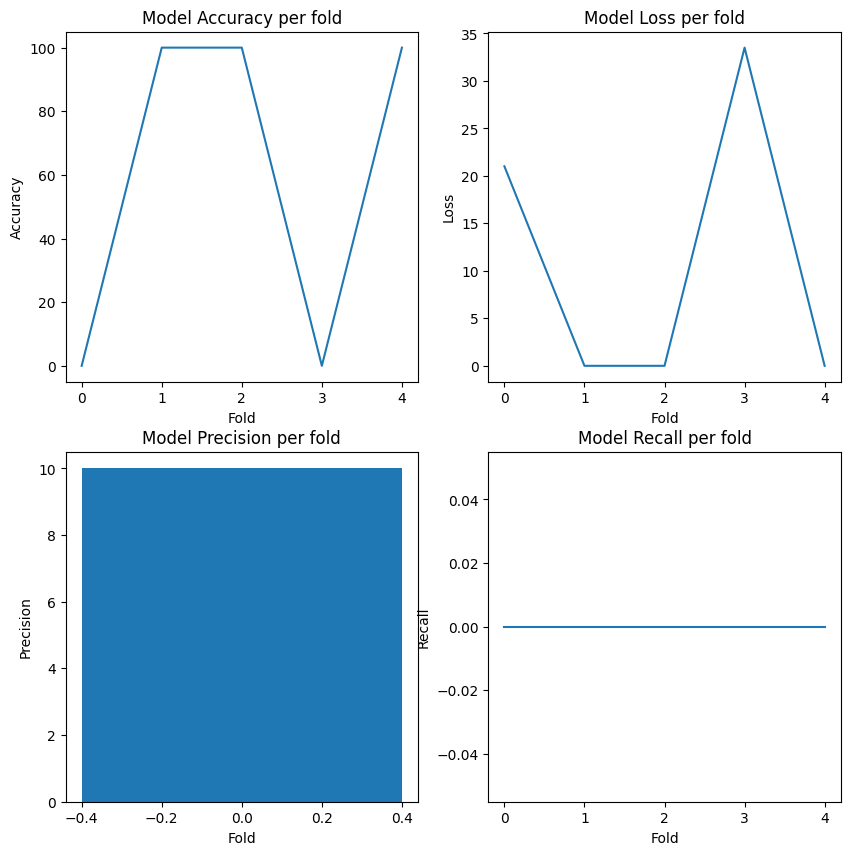

In [9]:
# Plotting Accuracy, Loss, Precision and Recall
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(acc_per_fold)
plt.title('Model Accuracy per fold')
plt.ylabel('Accuracy')
plt.xlabel('Fold')

plt.subplot(2,2,2)
plt.plot(loss_per_fold)
plt.title('Model Loss per fold')
plt.ylabel('Loss')
plt.xlabel('Fold')

plt.subplot(2,2,3)
#plt.plot(precision_per_fold)
plt.bar(precision_per_fold, height=10)
plt.title('Model Precision per fold')
plt.ylabel('Precision')
plt.xlabel('Fold')


plt.subplot(2,2,4)
plt.plot(recall_per_fold)
plt.title('Model Recall per fold')
plt.ylabel('Recall')
plt.xlabel('Fold')
plt.show()